In [14]:
import math
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, GaussianBlur
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as TF

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [15]:
# Toy dataset for experiments
dim = 784 # 28*28 = 784
r = 25  # bottleneck / testing rank

numToySamples = 10000
toy_mean = 0.0
toy_var = 0.05
toy_std = toy_var ** 0.5

X = torch.randn(dim, numToySamples, device=device) * toy_std + toy_mean
gammaX = toy_var * torch.eye(dim, device=device)
#gammaX += 1e-5 * torch.eye(dim, device=device)
L_X = torch.linalg.cholesky(gammaX)

# Condition number of gammaX
cond_gammaX = torch.linalg.cond(gammaX)
print(f"Condition number of gammaX: {cond_gammaX:.2e}")

# F matrix (blur)
blurKernelSizeF = 5
blurSigmaF = 1.5
forwardBlur = GaussianBlur(kernel_size=blurKernelSizeF, sigma=blurSigmaF)
basisImages = torch.eye(dim).reshape(dim, 1, 28, 28)
F_cols = []
for j in range(dim):
    F_cols.append(forwardBlur(basisImages[j]).flatten())
F = torch.stack(F_cols, dim=1).to(device)
FX = F @ X

# Condition number of F
cond_F = torch.linalg.cond(F)
print(f"Condition number of F: {cond_F:.2e}")

# Y = F(X) + noise
noiseSigma = 0.05
E = torch.randn_like(FX) * noiseSigma
Y = FX + E
muY = Y.mean(dim=1, keepdim=True)
Y = Y - muY
print(f"Noise sigma: {noiseSigma:.2e}")


# gammaY and gammaE
gammaE = noiseSigma**2 * torch.eye(dim, device=device)
gammaY = F @ gammaX @ F.T + gammaE #+ 1e-5 * torch.eye(dim, device=device)
L_Y = torch.linalg.cholesky(gammaY)

# Condition number of gammaY
cond_gammaY = torch.linalg.cond(gammaY)
print(f"Condition number of gammaY: {cond_gammaY:.2e}")

# Theoretical best M_r via SVD
M  = gammaX @ F.T @ torch.linalg.inv(gammaY)
U, S, Vh = torch.linalg.svd(M)

# Condition number of M
cond_M = torch.linalg.cond(M)
print(f"Condition number of M: {cond_M:.2e}")

U_r, S_r, Vh_r = U[:, :r], torch.diag(S[:r]), Vh[:r, :]
M_r = U_r @ S_r @ Vh_r

# Condition number of M_r
cond_M_r = torch.linalg.cond(M_r)
print(f"Condition number of M_r (rank-{r} truncation): {cond_M_r:.2e}")

# Theoretical error: average per-sample l2 discrepancy ------------------------
diffs_opt = M_r @ Y - X
rel_error_theory_train = torch.norm(diffs_opt, dim=0).mean().item()  # average over samples

print(f"Theoretical average per-sample L2 training error: {rel_error_theory_train:.4f}")

Condition number of gammaX: 1.00e+00
Condition number of F: 8.10e+04
Noise sigma: 5.00e-02
Condition number of gammaY: 2.17e+01
Condition number of M: 8.90e+03
Condition number of M_r (rank-25 truncation): 4.17e+10
Theoretical average per-sample L2 training error: 6.2075


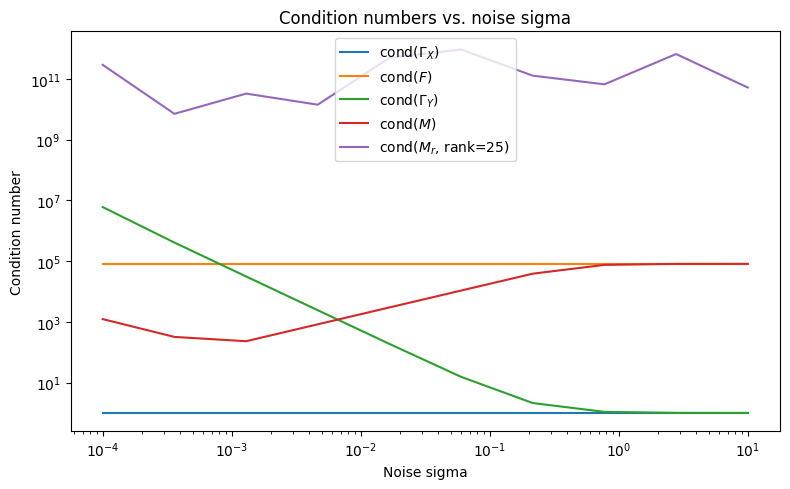

In [16]:
# ─────────────────────────────────────────────────────────────────────────────
# Plot condition numbers vs. noise sigma
# ─────────────────────────────────────────────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt

r = 25
# Define range of noise sigma values to test
noiseSigmas = np.logspace(-4, 1, 10)  

# Initialize storage
cond_gammaX_list = []
cond_F_list = []
cond_gammaY_list = []
cond_M_list = []
cond_M_r_list = []

# Sweep over noiseSigmas
for ns in noiseSigmas:
    # Recompute gammaE, gammaY, M, M_r at each noise sigma

    gammaE = ns**2 * torch.eye(dim, device=device)
    gammaY = F @ gammaX @ F.T + gammaE #+ 1e-5 * torch.eye(dim, device=device)

    M  = gammaX @ F.T @ torch.linalg.inv(gammaY)
    U, S, Vh = torch.linalg.svd(M)
    U_r, S_r, Vh_r = U[:, :r], torch.diag(S[:r]), Vh[:r, :]
    M_r = U_r @ S_r @ Vh_r

    # Record condition numbers
    cond_gammaX_list.append(torch.linalg.cond(gammaX).cpu().item())
    cond_F_list.append(torch.linalg.cond(F).cpu().item())
    cond_gammaY_list.append(torch.linalg.cond(gammaY).cpu().item())
    cond_M_list.append(torch.linalg.cond(M).cpu().item())
    cond_M_r_list.append(torch.linalg.cond(M_r).cpu().item())

# Plotting
plt.figure(figsize=(8,5))

plt.plot(noiseSigmas, cond_gammaX_list, label=r'cond($\Gamma_X$)')
plt.plot(noiseSigmas, cond_F_list, label=r'cond($F$)')
plt.plot(noiseSigmas, cond_gammaY_list, label=r'cond($\Gamma_Y$)')
plt.plot(noiseSigmas, cond_M_list, label=r'cond($M$)')
plt.plot(noiseSigmas, cond_M_r_list, label=fr'cond($M_r$, rank={r})')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Noise sigma')
plt.ylabel('Condition number')
plt.title('Condition numbers vs. noise sigma')
plt.legend()
plt.tight_layout()
plt.show()

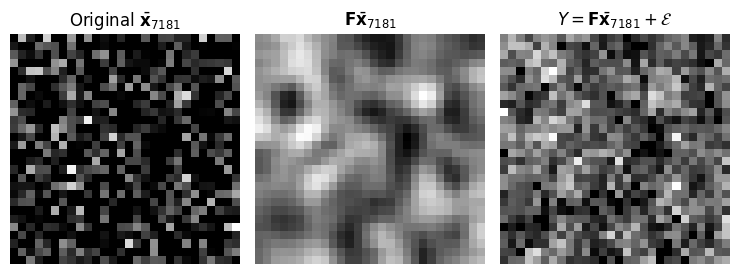

In [17]:
# ── quick 1×3 preview: (\bar{X}, F \bar{X}, F \bar{X} + E) ─────────────────────
import os
import matplotlib.pyplot as plt

idx = 7181

# (i) original image  →  (H,W)
orig_img = X[:, idx].view(28, 28).cpu().clamp(0, 1)

# (ii) blurred image  F \bar{X}
blur_img = forwardBlur(orig_img.unsqueeze(0)).squeeze(0).cpu()

# (iii) blurred + noise image  F \bar{X} + E
noise = torch.randn_like(blur_img) * noiseSigma
blur_noise_img = (blur_img + noise).clamp(0, 1).cpu()

# ── plot & save ──────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(7.5, 2.7))
axes[0].imshow(orig_img, cmap='gray')
axes[0].set_title(r'Original $\bar{\mathbf{x}}_{7181}$')
axes[0].axis('off')

axes[1].imshow(blur_img, cmap='gray')
axes[1].set_title(r'$\mathbf{F} \bar{\mathbf{x}}_{7181}$')
axes[1].axis('off')

axes[2].imshow(blur_noise_img, cmap='gray')
axes[2].set_title(r'$Y = \mathbf{F} \bar{\mathbf{x}}_{7181} + \mathcal{E}$')
axes[2].axis('off')

plt.tight_layout()

out_dir = f"end2endpics/MedMNIST"
os.makedirs(out_dir, exist_ok=True)
# plt.savefig(f"{out_dir}/{data_flag}_mapping{idx}_{r}.png", dpi=300)
plt.show() 

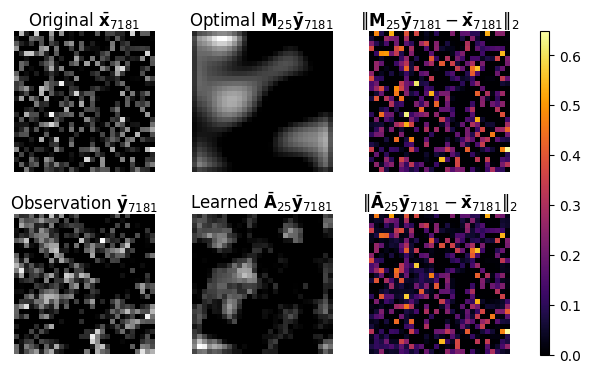

In [18]:
# --- Autoencoder setup -------------------------------------------------------
batch_size = 128
num_epochs = 350

X_tensor = X.clone().to(torch.float32)
Y_tensor = Y.clone().to(torch.float32)

class LinearAutoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super().__init__()
        self.encoder = nn.Linear(input_dim, bottleneck_dim, bias=False)
        self.decoder = nn.Linear(bottleneck_dim, input_dim, bias=False)
    def forward(self, x):
        return self.decoder(self.encoder(x))

model     = LinearAutoencoder(input_dim=dim, bottleneck_dim=r).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

train_errors = []
for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()

    outputs = model(Y.T)
    target  = X.T

    loss = criterion(outputs, target)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        A_learned = model.decoder.weight @ model.encoder.weight
        diffs = A_learned @ Y - X
        avg_l2_err = torch.norm(diffs, dim=0).mean().item()
        train_errors.append(avg_l2_err)

from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap

everforest_colors = [
    "#2d353b", "#3d484d", "#4f585e", "#566358", "#5a6f47",
    "#7a9c58", "#a7c080", "#dbbc7f", "#e69875", "#e67e80", "#dc5456"
]

everforest_cmap = LinearSegmentedColormap.from_list(
    'everforest_blend',
    everforest_colors,
    N=256
)

for _ in range(1):
    idx = 7181

    orig_img   = X[:, idx].view(28, 28).cpu().clamp(0, 1)
    y_img      = Y[:, idx].view(28, 28).cpu().clamp(0, 1)
    opt_img    = (M_r @ Y)[:, idx].view(28, 28).cpu().clamp(0, 1)
    learn_img  = (A_learned @ Y)[:, idx].view(28, 28).cpu().clamp(0, 1)

    err_opt   = torch.abs(opt_img - orig_img)
    err_learn = torch.abs(learn_img - orig_img)
    err_vmin, err_vmax = 0.0, max(err_opt.max(), err_learn.max()).item()

    fig = plt.figure(figsize=(7, 4.2))
    gs  = gridspec.GridSpec(2, 4, width_ratios=[1, 1, 1, 0.06], wspace=0.20, hspace=0.30)

    ax = fig.add_subplot(gs[0, 0])
    ax.imshow(orig_img, cmap='gray')
    ax.set_title(r'Original $\bar{\mathbf{x}}_{7181}$', pad=4)
    ax.axis('off')

    ax = fig.add_subplot(gs[0, 1])
    ax.imshow(opt_img, cmap='gray')
    ax.set_title(r'Optimal $\mathbf{M}_{25} \bar{\mathbf{y}}_{7181}$', pad=4)
    ax.axis('off')

    ax = fig.add_subplot(gs[0, 2])
    im = ax.imshow(err_opt, cmap='inferno', vmin=err_vmin, vmax=err_vmax)
    ax.set_title(r'$\|\mathbf{M}_{25} \bar{\mathbf{y}}_{7181} - \bar{\mathbf{x}}_{7181}\|_2$', pad=4)
    ax.axis('off')

    ax = fig.add_subplot(gs[1, 0])
    ax.imshow(y_img, cmap='gray')
    ax.set_title(r'Observation $\bar{\mathbf{y}}_{7181}$', pad=4)
    ax.axis('off')

    ax = fig.add_subplot(gs[1, 1])
    ax.imshow(learn_img, cmap='gray')
    ax.set_title(r'Learned $\bar{\mathbf{A}}_{25} \bar{\mathbf{y}}_{7181}$', pad=4)
    ax.axis('off')

    ax = fig.add_subplot(gs[1, 2])
    ax.imshow(err_learn, cmap='inferno', vmin=err_vmin, vmax=err_vmax)
    ax.set_title(r'$\|\bar{\mathbf{A}}_{25} \bar{\mathbf{y}}_{7181} - \bar{\mathbf{x}}_{7181}\|_2$', pad=4)
    ax.axis('off')

    cax = fig.add_subplot(gs[:, 3])
    plt.colorbar(im, cax=cax)
    cax.yaxis.tick_right()
    # plt.savefig(f"end2endpics/MedMNIST/sample{idx}_{numToySamples}_{r}.png")
    plt.show()

In [19]:
# ════════════════════════════════════════════════════════════════════════════
# TOY DATASET RANK SWEEP
#   • Uses precomputed X, Y, gammaX, M, etc.
#   • Computes theory and learned errors for each rank
# ════════════════════════════════════════════════════════════════════════════

import torch
import matplotlib.pyplot as plt

# Assuming X, Y, gammaX, M are precomputed and in memory
U, S, Vh = torch.linalg.svd(M)

ranks = list(range(25, 776, 25))
theory_err, learned_err = [], []

for r in ranks:
    # Bayes-optimal map (truncated SVD)
    U_r, S_r, Vh_r = U[:, :r], torch.diag(S[:r]), Vh[:r, :]
    M_r = U_r @ S_r @ Vh_r
    diffs_opt = M_r @ Y - X
    avg_l2_opt = torch.norm(diffs_opt, dim=0).mean().item()
    theory_err.append(avg_l2_opt)

    # Linear autoencoder of rank r
    ae = LinearAutoencoder(dim, r).to(device)
    opt = optim.Adam(ae.parameters(), lr=1e-3)
    for _ in range(350):
        opt.zero_grad()
        out = ae(Y.T)
        loss = criterion(out, X.T)
        loss.backward()
        opt.step()

    with torch.no_grad():
        W_enc = ae.encoder.weight.detach()
        W_dec = ae.decoder.weight.detach()
        A = W_dec @ W_enc
        diffs_learn = A.to(device) @ Y - X
        avg_l2_learn = torch.norm(diffs_learn, dim=0).mean().item()
    learned_err.append(avg_l2_learn)




<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
C:\Users\alexr\AppData\Local\Temp\ipykernel_5040\4245288839.py:8: SyntaxWarning: invalid escape sequence '\e'
  plt.title('Toy Dataset: Average $\ell_2$ Error vs. Rank')


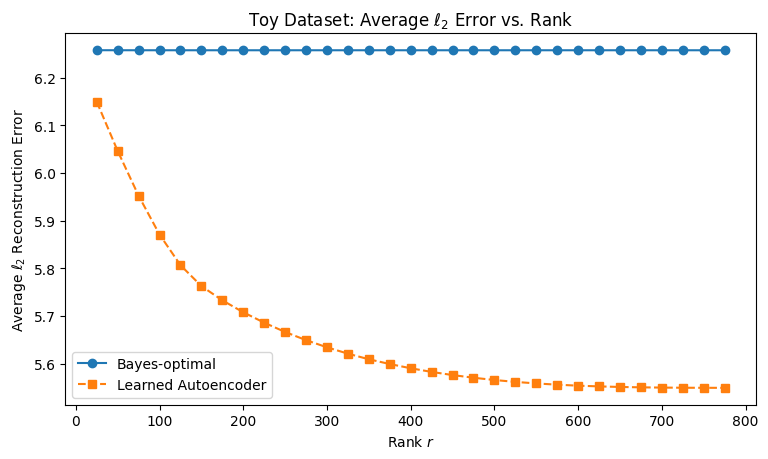

In [20]:
# Plot results
plt.figure(figsize=(7.8, 4.7))
plt.plot(ranks, theory_err, '-', marker='o', label='Bayes-optimal')
plt.plot(ranks, learned_err, '--', marker='s', label='Learned Autoencoder')
plt.xlabel('Rank $r$')
plt.ylabel(r'Average $\ell_2$ Reconstruction Error')
#plt.yscale('log')
plt.title('Toy Dataset: Average $\ell_2$ Error vs. Rank')
plt.legend()
plt.tight_layout()
plt.show()